Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [39]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 2 - Data Preprocessing

## 2.1 Converting prices to returns

### How to do it...

1. Import the libraries:

In [41]:
import pandas as pd 
import numpy as np
import yfinance as yf

2. Download the data and keep the adjusted close prices only:

In [42]:
df = yf.download("AAPL", 
                 start="2010-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df.loc[:, ["Adj Close"]]

3. Convert adjusted close prices to simple and log returns:

In [43]:
df["simple_rtn"] = df["Adj Close"].pct_change()
df["log_rtn"] = np.log(df["Adj Close"]/df["Adj Close"].shift(1))

4. Inspect the output:

In [44]:
df.head()

,Adj Close,simple_rtn,log_rtn
Date,,,
2010-01-04,6.470742,NaN,NaN
2010-01-05,6.481928,0.001729,0.001727
2010-01-06,6.378824,-0.015906,-0.016034
2010-01-07,6.367032,-0.001849,-0.001850
2010-01-08,6.409363,0.006649,0.006626


## 2.2 Adjusting the returns for inflation

### How to do it...

0. Recreating the steps from the previous recipe:

In [45]:
import yfinance as yf

df = yf.download("AAPL", 
                 start="2010-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df.loc[:, ["Adj Close"]]
df.index.name = "date"
df.head()

,Adj Close
date,
2010-01-04,6.470742
2010-01-05,6.481928
2010-01-06,6.378824
2010-01-07,6.367032
2010-01-08,6.409363


2. Resample daily prices to monthly:

In [46]:
df_resampled = df.resample('BMS').first()
df_resampled

,Adj Close
date,
2010-01-01,6.470742
2010-02-01,5.887795
2010-03-01,6.318959
2010-04-01,7.134716
2010-05-03,8.053276
...,...
2020-08-03,106.534309
2020-09-01,131.456573
2020-10-01,114.419518


1. Import the library:

In [47]:
import cpi

In [48]:
# in the case of seeing the `StaleDataWarning: CPI data is out of date`
cpi.update()

2. Obtain the default CPI series:

In [49]:
cpi_series = cpi.series.get()
cpi_series

<Series: CUUR0000SA0: All items in U.S. city average, all urban consumers, not seasonally adjusted>

In [50]:
print(cpi_series)

CUUR0000SA0: All items in U.S. city average, all urban consumers, not seasonally adjusted


3. Convert the object into a `pandas` DataFrame:

In [51]:
df_cpi_2 = cpi_series.to_dataframe()

4. Filter the DataFrame and view the top 12 observations:

In [52]:
df_cpi_2_filtered = df_cpi_2.query("period_type == 'monthly' and year >= 2010") \
        .loc[:, ["date", "value"]] \
        .set_index("date") \
        .rename(columns={"value": "cpi"}) 
df_cpi_2_filtered.index = pd.to_datetime(df_cpi_2_filtered.index)

df_cpi_2_filtered.head(12)


,cpi
date,
2010-01-01,216.687
2010-02-01,216.741
2010-03-01,217.631
2010-04-01,218.009
2010-05-01,218.178
2010-06-01,217.965
2010-07-01,218.011
2010-08-01,218.312
2010-09-01,218.439


4. Join inflation data to prices:
5. Calculate simple returns and inflation rate:
6. Adjust the returns for inflation:

In [53]:
df_j = df_resampled.join(df_cpi_2_filtered, how="left")
df_j["simple_rtn"] = df_j["Adj Close"].pct_change()
df_j["inflation_rate"] = df_j["cpi"].pct_change()
df_j["real_rtn"] = (
    (df_j["simple_rtn"] + 1) / (df_j["inflation_rate"] + 1) - 1
)
df_j.head()

,Adj Close,cpi,simple_rtn,inflation_rate,real_rtn
date,,,,,
2010-01-01,6.470742,216.687,NaN,NaN,NaN
2010-02-01,5.887795,216.741,-0.090090,0.000249,-0.090316
2010-03-01,6.318959,217.631,0.073230,0.004106,0.068841
2010-04-01,7.134716,218.009,0.129097,0.001737,0.127139
2010-05-03,8.053276,NaN,0.128745,0.000000,0.128745


## 2.3 Changing the frequency of time series data

### How to do it...

0. Obtain the log returns in case of starting in this recipe:

In [54]:
import pandas as pd 
import yfinance as yf
import numpy as np

# download data 
df = yf.download("AAPL", 
                 start="2000-01-01", 
                 end="2010-12-31", 
                 auto_adjust=False,
                 progress=False)

# keep only the adjusted close price
df = df.loc[:, ["Adj Close"]] \
       .rename(columns={"Adj Close": "adj_close"})

# calculate simple returns
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))

# remove redundant data
df = df.drop("adj_close", axis=1) \
       .dropna(axis=0)

df.head()

,log_rtn
Date,
2000-01-04,-0.088077
2000-01-05,0.014527
2000-01-06,-0.090514
2000-01-07,0.046281
2000-01-10,-0.017744


1. Import the libraries:

In [55]:
import pandas as pd 
import numpy as np

2. Define the function for calculating the realized volatility:

In [56]:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

3. Calculate monthly realized volatility:

In [57]:
df_rv = (
    df.groupby(pd.Grouper(freq="M"))
    .apply(realized_volatility)
    .rename(columns={"log_rtn": "rv"})
)

4. Annualize the values:

In [58]:
df_rv.rv = df_rv["rv"] * np.sqrt(12)

5. Plot the results:

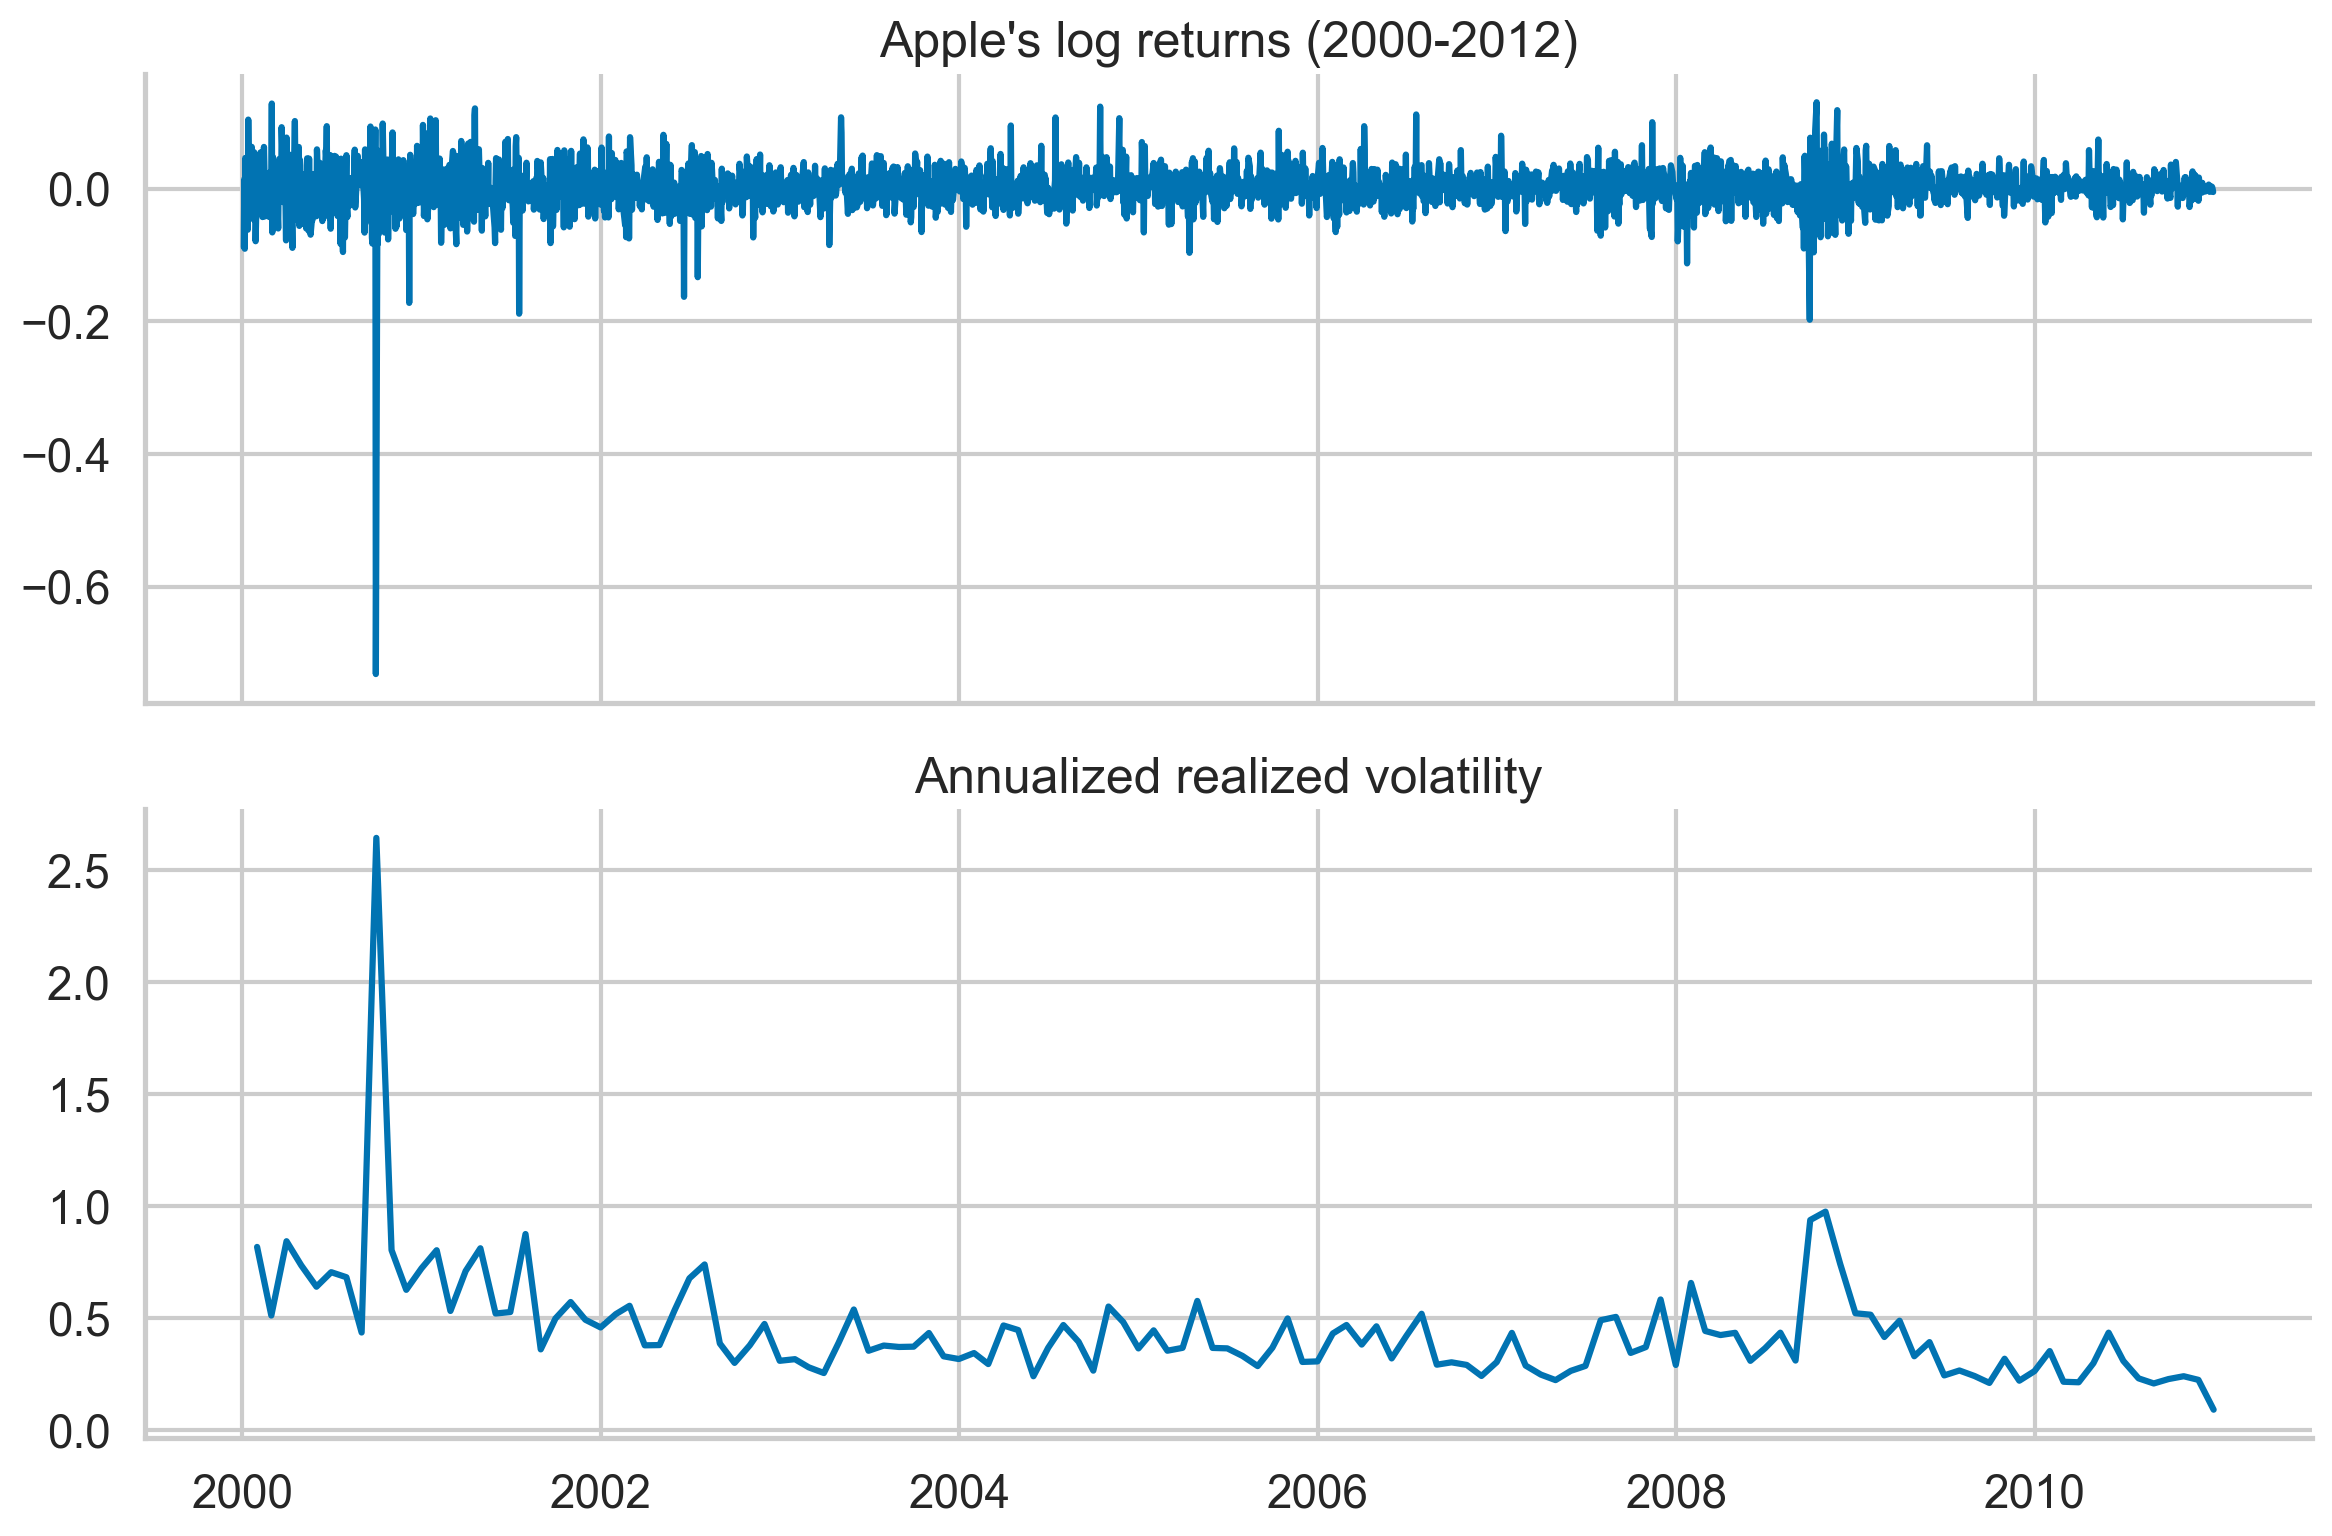

In [59]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[0].set_title("Apple's log returns (2000-2012)")
ax[1].plot(df_rv)
ax[1].set_title("Annualized realized volatility")

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_2_5', dpi=200)

## 2.4 Different ways of imputing missing data

### How to do it...

1. Import the libraries:

In [60]:
import pandas as pd
import numpy as np
import cpi


2. Download the inflation data:

In [61]:
cpi.update()
cpi_series = cpi.series.get()
df = cpi_series.to_dataframe().query("period_type == 'monthly' and year >= 2015") \
        .loc[:, ["date", "value"]] \
        .set_index("date") \
        .rename(columns={"value": "cpi"}) 
df.index = pd.to_datetime(df.index)

3. Introduce 5 missing values at random:

In [62]:
np.random.seed(42)
rand_indices = np.random.choice(df.index, 5, replace=False)

df["cpi_missing"] = df.loc[:, "cpi"]
df.loc[rand_indices, "cpi_missing"] = np.nan
df.head()

,cpi,cpi_missing
date,,
2015-01-01,233.707,233.707
2015-02-01,234.722,234.722
2015-03-01,236.119,236.119
2015-04-01,236.599,236.599
2015-05-01,237.805,NaN


4. Fill the missing values using different methods:

In [63]:
for method in ["bfill", "ffill"]:
    df[f"method_{method}"] = (
        df[["cpi_missing"]].fillna(method=method)
    )

5. Inspect the results by displaying the rows in which we created the missing values:

In [64]:
df.loc[rand_indices].sort_index()

,cpi,cpi_missing,method_bfill,method_ffill
date,,,,
2015-05-01,237.805,NaN,238.638,236.599
2015-11-01,237.336,NaN,236.525,237.838
2020-05-01,256.394,NaN,257.797,256.389
2021-07-01,273.003,NaN,273.567,271.696
2022-01-01,281.148,NaN,283.716,278.802


6. Plot the results for years 2015-2016:

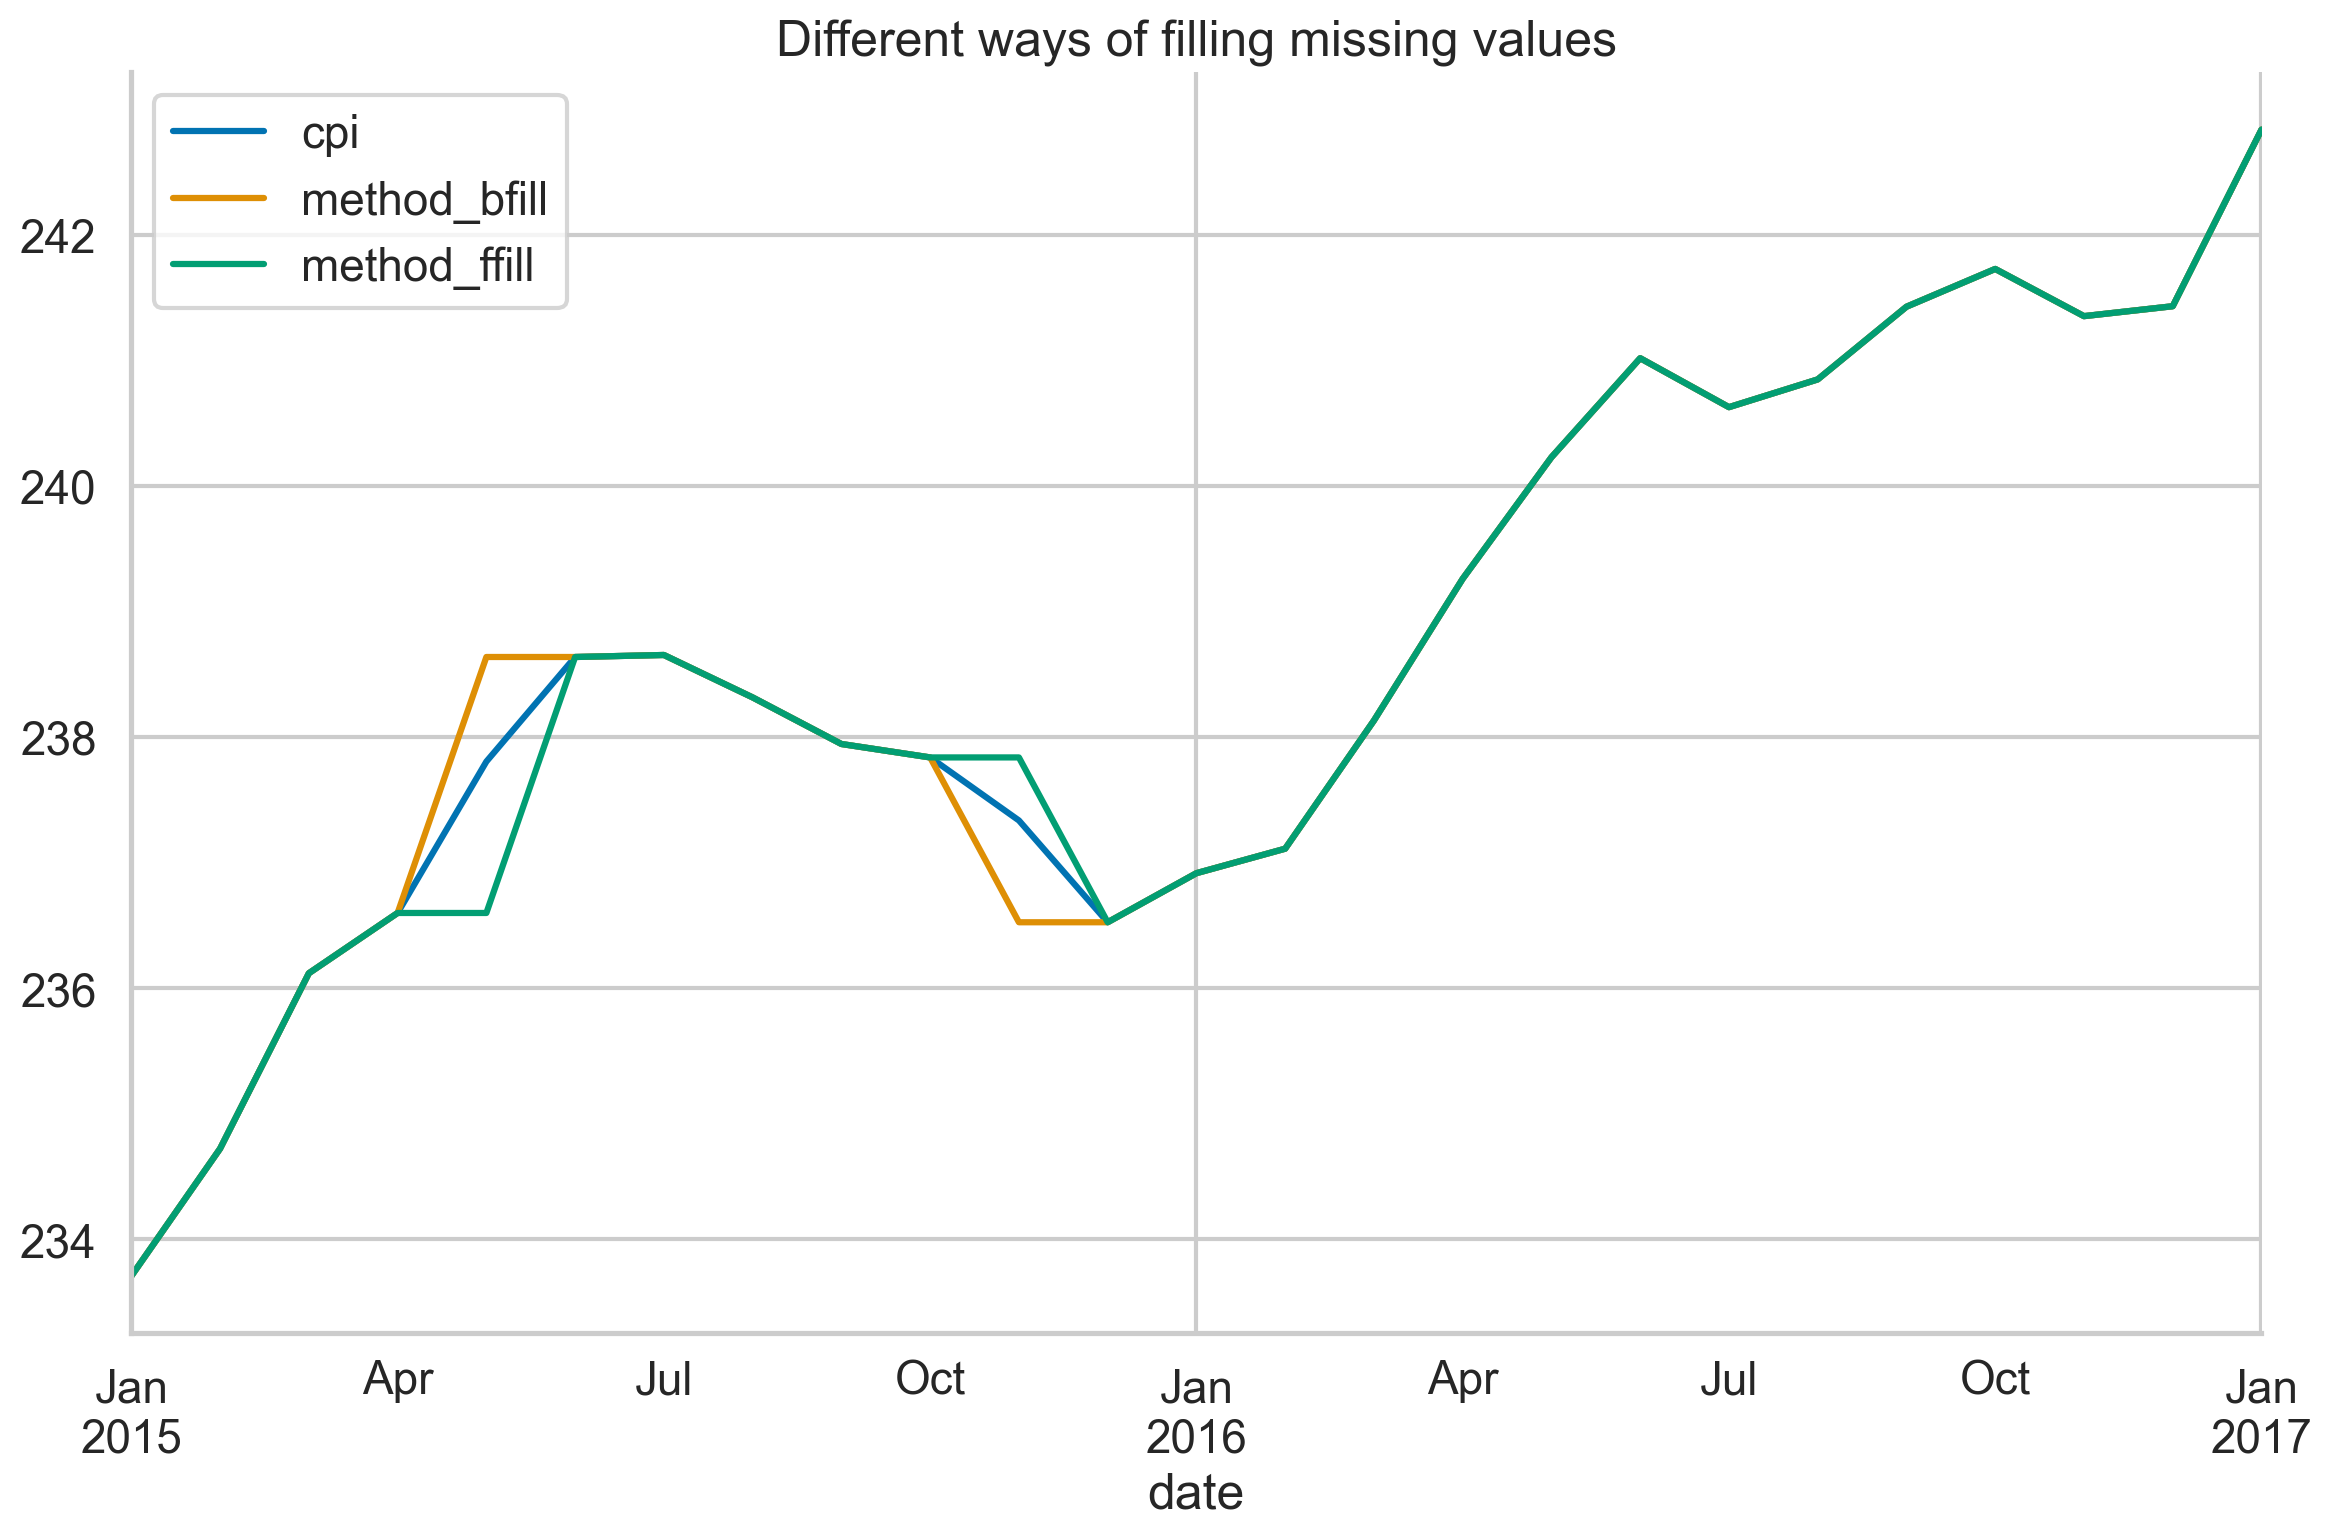

In [65]:
df.loc[:"2017-01-01"] \
  .drop(columns=["cpi_missing"]) \
  .plot(title="Different ways of filling missing values");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_2_8', dpi=200)

### There's more

1. Use linear interpolation to fill the missing values:

In [66]:
df["method_interpolate"] = df[["cpi_missing"]].interpolate()

2. Inspect the results:

In [67]:
df.loc[rand_indices].sort_index()

,cpi,cpi_missing,method_bfill,method_ffill,method_interpolate
date,,,,,
2015-05-01,237.805,NaN,238.638,236.599,237.6185
2015-11-01,237.336,NaN,236.525,237.838,237.1815
2020-05-01,256.394,NaN,257.797,256.389,257.0930
2021-07-01,273.003,NaN,273.567,271.696,272.6315
2022-01-01,281.148,NaN,283.716,278.802,281.2590


3. Plot the results:

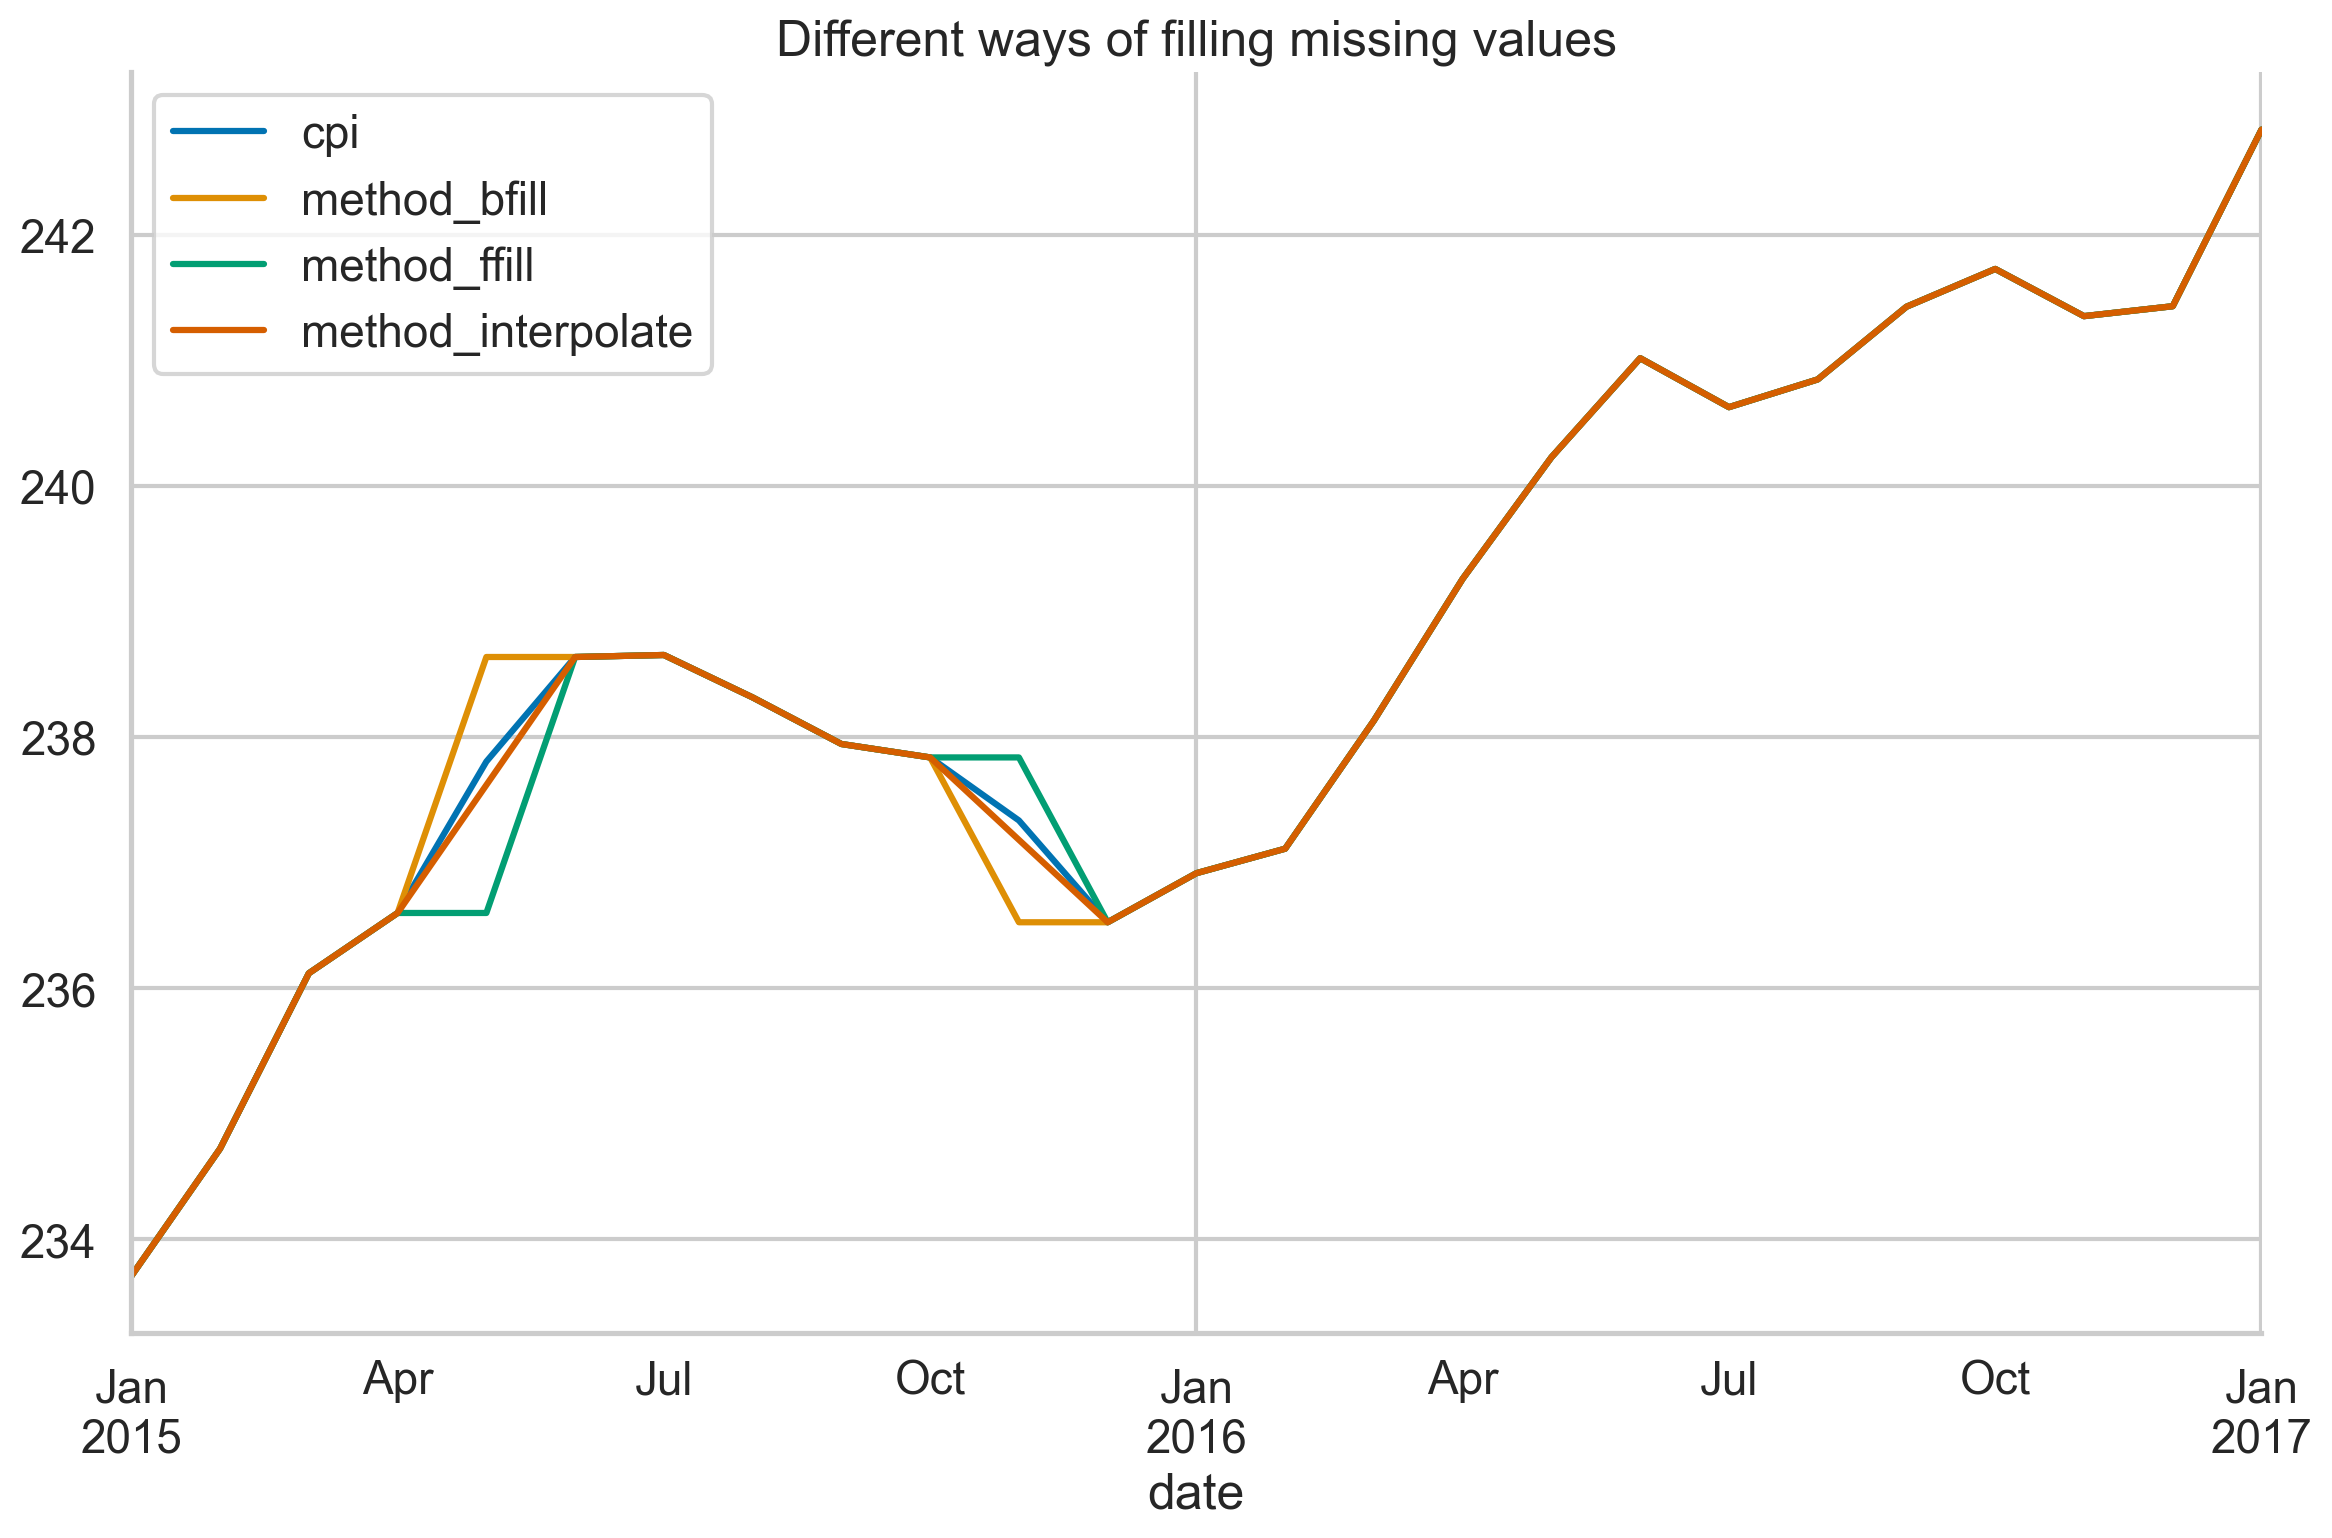

In [68]:
df.loc[:"2017-01-01"] \
  .drop(columns=["cpi_missing"]) \
  .plot(title="Different ways of filling missing values");

sns.despine()
plt.tight_layout()
# plt.savefig('images/figure_2_10', dpi=200)

## 2.6 Different ways of aggregating trade data

### How to do it...

1. Import the libraries:

In [69]:
from binance.spot import Spot as Client
import pandas as pd 
import numpy as np


2. Instantiate the Binance client and download the last 500 `BTCEUR` trades:

In [70]:
spot_client = Client(base_url="https://api3.binance.com")
r = spot_client.trades("BTCEUR")

3. Process the downloaded trades into a `pandas` DataFrame:

In [71]:
df = (
    pd.DataFrame(r)
    .drop(columns=["isBuyerMaker", "isBestMatch"])
)
df["time"] = pd.to_datetime(df["time"], unit="ms")

for column in ["price", "qty", "quoteQty"]:
    df[column] = pd.to_numeric(df[column])
df

,id,price,qty,quoteQty,time
0,131794434,47725.76,0.00060,28.635456,2024-02-22 09:40:11.258
1,131794435,47725.76,0.00225,107.382960,2024-02-22 09:40:11.258
2,131794436,47726.24,0.00891,425.240798,2024-02-22 09:40:15.904
3,131794437,47726.24,0.00079,37.703730,2024-02-22 09:40:16.704
4,131794438,47726.24,0.00042,20.045021,2024-02-22 09:40:18.604
...,...,...,...,...,...
495,131794929,47946.87,0.01181,566.252535,2024-02-22 09:55:32.304
496,131794930,47946.88,0.00417,199.938490,2024-02-22 09:55:32.304
497,131794931,47949.62,0.00933,447.369955,2024-02-22 09:55:32.304
498,131794932,47955.65,0.00021,10.070687,2024-02-22 09:55:32.304


4. Define a function aggregating the raw trades information:

In [72]:
def get_bars(df, add_time=False):
    """[summary]

    Args:
        df ([type]): [description]

    Returns:
        [type]: [description]
    """
    ohlc = df["price"].ohlc()
    vwap = (
        df.apply(lambda x: np.average(x["price"], weights=x["qty"]))
        .to_frame("vwap")
    )
    vol = df["qty"].sum().to_frame("vol")
    cnt = df["qty"].size().to_frame("cnt")
    
    if add_time:
        time = df["time"].last().to_frame("time")
        res = pd.concat([time, ohlc, vwap, vol, cnt], axis=1)
    else:
        res = pd.concat([ohlc, vwap, vol, cnt], axis=1)
    return res

5. Get time bars:

In [73]:
df_grouped_time = df.groupby(pd.Grouper(key="time", freq="1Min"))
time_bars = get_bars(df_grouped_time)
time_bars

,open,high,low,close,vwap,vol,cnt
time,,,,,,,
2024-02-22 09:40:00,47725.76,47830.60,47725.76,47825.43,47778.776887,2.75556,87
2024-02-22 09:41:00,47818.24,47829.83,47782.75,47785.16,47815.997221,0.33184,40
2024-02-22 09:42:00,47788.33,47826.56,47776.65,47826.53,47789.972912,0.14123,19
2024-02-22 09:43:00,47823.13,47831.57,47812.28,47812.28,47826.286808,0.03440,11
2024-02-22 09:44:00,47816.93,47834.53,47813.40,47834.53,47820.722896,0.02479,7
2024-02-22 09:45:00,47845.78,47871.27,47834.38,47852.54,47855.356743,0.89005,74
2024-02-22 09:46:00,47858.12,47873.92,47835.19,47835.19,47854.518639,0.18640,25
2024-02-22 09:47:00,47835.01,47835.01,47817.41,47824.85,47823.771126,0.37198,28
2024-02-22 09:48:00,47833.86,47866.24,47831.14,47866.18,47855.215578,0.39846,27


6. Get tick bars:

In [74]:
bar_size = 50 
df["tick_group"] = (
    pd.Series(list(range(len(df))))
    .div(bar_size)
    .apply(np.floor)
    .astype(int)
    .values
)
df_grouped_ticks = df.groupby("tick_group")
tick_bars = get_bars(df_grouped_ticks, add_time=True)
tick_bars

,time,open,high,low,close,vwap,vol,cnt
tick_group,,,,,,,,
0,2024-02-22 09:40:44.353,47725.76,47817.58,47725.76,47817.58,47762.820310,1.99966,50
1,2024-02-22 09:41:02.484,47817.57,47830.60,47801.32,47829.07,47821.636838,0.84905,50
2,2024-02-22 09:43:16.800,47829.36,47829.83,47776.65,47826.59,47804.551156,0.39560,50
3,2024-02-22 09:45:44.895,47830.69,47859.89,47812.28,47859.39,47850.404034,0.36599,50
4,2024-02-22 09:46:34.700,47859.39,47873.92,47851.05,47855.82,47857.341495,0.66690,50
5,2024-02-22 09:48:27.655,47849.15,47866.19,47817.41,47866.19,47837.150400,0.74107,50
6,2024-02-22 09:49:44.423,47866.19,47936.83,47855.81,47901.25,47902.976205,0.44926,50
7,2024-02-22 09:51:28.611,47901.25,47918.03,47870.99,47900.08,47897.762086,0.43221,50
8,2024-02-22 09:53:30.848,47912.55,47956.30,47900.02,47954.64,47927.639007,0.47120,50


7. Get volume bars:

In [75]:
bar_size = 1 
df["cum_qty"] = df["qty"].cumsum()
df["vol_group"] = (
    df["cum_qty"]
    .div(bar_size)
    .apply(np.floor)
    .astype(int)
    .values
)
df_grouped_ticks = df.groupby("vol_group")
volume_bars = get_bars(df_grouped_ticks, add_time=True)
volume_bars

,time,open,high,low,close,vwap,vol,cnt
vol_group,,,,,,,,
0,2024-02-22 09:40:39.299,47725.76,47756.65,47725.76,47756.65,47743.926266,0.78701,28
1,2024-02-22 09:40:44.353,47756.65,47817.58,47756.65,47817.58,47775.082546,1.21265,22
2,2024-02-22 09:41:14.011,47817.57,47830.60,47801.32,47806.83,47821.874936,0.98725,61
3,2024-02-22 09:45:52.748,47806.84,47869.55,47776.65,47869.55,47837.708091,1.00409,108
4,2024-02-22 09:48:26.523,47869.55,47873.92,47817.41,47857.00,47843.221936,1.00412,79
5,2024-02-22 09:52:01.512,47866.19,47936.83,47855.81,47918.53,47900.748628,0.99994,111
6,2024-02-22 09:55:32.304,47920.05,47967.78,47900.02,47956.59,47941.854282,0.77158,91


8. Get dollar bars:

In [76]:
bar_size = 50000 
df["cum_value"] = df["quoteQty"].cumsum()
df["value_group"] = (
    df["cum_value"]
    .div(bar_size)
    .apply(np.floor)
    .astype(int)
    .values
)
df_grouped_ticks = df.groupby("value_group")
dollar_bars = get_bars(df_grouped_ticks, add_time=True)
dollar_bars

,time,open,high,low,close,vwap,vol,cnt
value_group,,,,,,,,
0,2024-02-22 09:40:39.299,47725.76,47756.65,47725.76,47756.65,47743.926266,0.78701,28
1,2024-02-22 09:40:49.501,47756.65,47820.64,47756.65,47820.64,47777.774401,1.30450,30
2,2024-02-22 09:42:08.458,47823.27,47830.60,47782.75,47785.16,47818.357390,1.04660,72
3,2024-02-22 09:45:59.566,47787.43,47871.27,47776.65,47852.54,47848.097760,1.03976,108
4,2024-02-22 09:49:28.044,47858.12,47918.79,47817.41,47918.79,47846.871436,1.05114,94
5,2024-02-22 09:53:09.588,47936.83,47947.20,47870.99,47947.20,47913.355774,1.04265,109
6,2024-02-22 09:55:32.304,47944.74,47967.78,47937.08,47956.59,47951.820682,0.49498,59
